# [Tensorflow - Help Protect the Great Barrier Reef](https://www.kaggle.com/c/tensorflow-great-barrier-reef)
> Detect crown-of-thorns starfish in underwater image data

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/31703/logos/header.png?t=2021-10-29-00-30-04">

## 📒 Notebooks:
* Train: [Great-Barrier-Reef: YOLOv5 [train] 🌊](https://www.kaggle.com/awsaf49/great-barrier-reef-yolov5-train)
* Infer: [Great-Barrier-Reef: YOLOv5 [infer] 🌊](https://www.kaggle.com/awsaf49/great-barrier-reef-yolov5-infer)

# look for Yolov8

# 🛠 Install Libraries

In [ ]:
!pip install -qU wandb
!pip install -qU bbox-utility # check https://github.com/awsaf49/bbox for source code

# 📚 Import Libraries

In [ ]:
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import glob

import shutil
import sys
sys.path.append('../input/tensorflow-great-barrier-reef')

from joblib import Parallel, delayed

from IPython.display import display

# 📌 Key-Points
* One have to submit prediction using the provided **python time-series API**, which makes this competition different from previous Object Detection Competitions.
* Each prediction row needs to include all bounding boxes for the image. Submission is format seems also **COCO** which means `[x_min, y_min, width, height]`
* Copmetition metric `F2` tolerates some false positives(FP) in order to ensure very few starfish are missed. Which means tackling **false negatives(FN)** is more important than false positives(FP). 
$$F2 = 5 \cdot \frac{precision \cdot recall}{4\cdot precision + recall}$$

# ⭐ WandB
<img src="https://camo.githubusercontent.com/dd842f7b0be57140e68b2ab9cb007992acd131c48284eaf6b1aca758bfea358b/68747470733a2f2f692e696d6775722e636f6d2f52557469567a482e706e67" width=600>

Weights & Biases (W&B) is MLOps platform for tracking our experiemnts. We can use it to Build better models faster with experiment tracking, dataset versioning, and model management. Some of the cool features of W&B:

* Track, compare, and visualize ML experiments
* Get live metrics, terminal logs, and system stats streamed to the centralized dashboard.
* Explain how your model works, show graphs of how model versions improved, discuss bugs, and demonstrate progress towards milestones.


In [ ]:
import wandb

try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("WANDB")
    wandb.login(key=api_key)
    anonymous = None
except:
    wandb.login(anonymous='must')
    print('To use your W&B account,\nGo to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB. \nGet your W&B access token from here: https://wandb.ai/authorize')

# 📖 Meta Data
* `train_images/` - Folder containing training set photos of the form `video_{video_id}/{video_frame}.jpg`.

* `[train/test].csv` - Metadata for the images. As with other test files, most of the test metadata data is only available to your notebook upon submission. Just the first few rows available for download.

* `video_id` - ID number of the video the image was part of. The video ids are not meaningfully ordered.
* `video_frame` - The frame number of the image within the video. Expect to see occasional gaps in the frame number from when the diver surfaced.
* `sequence` - ID of a gap-free subset of a given video. The sequence ids are not meaningfully ordered.
* `sequence_frame` - The frame number within a given sequence.
* `image_id` - ID code for the image, in the format `{video_id}-{video_frame}`
* `annotations` - The bounding boxes of any starfish detections in a string format that can be evaluated directly with Python. Does not use the same format as the predictions you will submit. Not available in test.csv. A bounding box is described by the pixel coordinate `(x_min, y_min)` of its lower left corner within the image together with its `width` and `height` in pixels --> (COCO format).

In [ ]:
FOLD      = 1 # which fold to train
DIM       = 3000 
MODEL     = 'yolov5s'
BATCH     = 4
EPOCHS    = 3
OPTMIZER  = 'Adam'

PROJECT   = 'great-barrier-reef' # w&b in yolov5
NAME      = f'{MODEL}-dim{DIM}-fold{FOLD}' # w&b for yolov5

REMOVE_NOBBOX = True # remove images with no bbox
ROOT_DIR  = '/kaggle/input/tensorflow-great-barrier-reef/'
IMAGE_DIR = '/kaggle/images' # directory to save images
LABEL_DIR = '/kaggle/labels' # directory to save labels

## Create Directories

In [ ]:
!mkdir -p {IMAGE_DIR}
!mkdir -p {LABEL_DIR}

## Get Paths

In [ ]:
# Train Data
df = pd.read_csv(f'{ROOT_DIR}/train.csv')
df['old_image_path'] = f'{ROOT_DIR}/train_images/video_'+df.video_id.astype(str)+'/'+df.video_frame.astype(str)+'.jpg'
df['image_path']  = f'{IMAGE_DIR}/'+df.image_id+'.jpg'
df['label_path']  = f'{LABEL_DIR}/'+df.image_id+'.txt'
df['annotations'] = df['annotations'].progress_apply(eval)
display(df.head(2))

## Number of BBoxes
> Nearly 80% images are without any bbox.

In [ ]:
df['num_bbox'] = df['annotations'].progress_apply(lambda x: len(x))
data = (df.num_bbox>0).value_counts(normalize=True)*100
print(f"No BBox: {data[0]:0.2f}% | With BBox: {data[1]:0.2f}%")

# 🧹 Clean Data
* In this notebook, we use only **bboxed-images** (`~5k`). We can use all `~23K` images for train but most of them don't have any labels. So it would be easier to carry out experiments using only **bboxed images**.

In [ ]:
if REMOVE_NOBBOX:
    df = df.query("num_bbox>0")

# ✏️ Write Images
* We need to copy the Images to Current Directory(`/kaggle/working`) as `/kaggle/input` doesn't have **write access** which is needed for **YOLOv5**.
* We can make this process faster using **Joblib** which uses **Parallel** computing.

In [ ]:
def make_copy(row):
    shutil.copyfile(row.old_image_path, row.image_path)
    return

In [ ]:
image_paths = df.old_image_path.tolist()
_ = Parallel(n_jobs=-1, backend='threading')(delayed(make_copy)(row) for _, row in tqdm(df.iterrows(), total=len(df)))

# 🔨 Helper

In [ ]:
# check https://github.com/awsaf49/bbox for source code of following utility functions
from bbox.utils import coco2yolo, coco2voc, voc2yolo
from bbox.utils import draw_bboxes, load_image
from bbox.utils import clip_bbox, str2annot, annot2str

def get_bbox(annots):
    bboxes = [list(annot.values()) for annot in annots]
    return bboxes

def get_imgsize(row):
    row['width'], row['height'] = imagesize.get(row['image_path'])
    return row

np.random.seed(32)
colors = [(np.random.randint(255), np.random.randint(255), np.random.randint(255))\
          for idx in range(1)]

## Create BBox

In [ ]:
df['bboxes'] = df.annotations.progress_apply(get_bbox)
df.head(2)

## Get Image-Size
> All Images have same dimension, [Width, Height] =  `[1280, 720]`

In [ ]:
df['width']  = 1280
df['height'] = 720
display(df.head(2))

# 🏷️ Create Labels
We need to export our labels to **YOLO** format, with one `*.txt` file per image (if no objects in image, no `*.txt` file is required). The *.txt file specifications are:

* One row per object
* Each row is class `[x_center, y_center, width, height]` format.
* Box coordinates must be in **normalized** `xywh` format (from `0 - 1`). If your boxes are in pixels, divide `x_center` and `width` by `image width`, and `y_center` and `height` by `image height`.
* Class numbers are **zero-indexed** (start from `0`).

> Competition bbox format is **COCO** hence `[x_min, y_min, width, height]`. So, we need to convert form **COCO** to **YOLO** format.


In [ ]:
cnt = 0
all_bboxes = []
bboxes_info = []
for row_idx in tqdm(range(df.shape[0])):
    row = df.iloc[row_idx]
    image_height = row.height
    image_width  = row.width
    bboxes_coco  = np.array(row.bboxes).astype(np.float32).copy()
    num_bbox     = len(bboxes_coco)
    names        = ['cots']*num_bbox
    labels       = np.array([0]*num_bbox)[..., None].astype(str)
    ## Create Annotation(YOLO)
    with open(row.label_path, 'w') as f:
        if num_bbox<1:
            annot = ''
            f.write(annot)
            cnt+=1
            continue
        bboxes_voc  = coco2voc(bboxes_coco, image_height, image_width)
        bboxes_voc  = clip_bbox(bboxes_voc, image_height, image_width)
        bboxes_yolo = voc2yolo(bboxes_voc, image_height, image_width).astype(str)
        all_bboxes.extend(bboxes_yolo.astype(float))
        bboxes_info.extend([[row.image_id, row.video_id, row.sequence]]*len(bboxes_yolo))
        annots = np.concatenate([labels, bboxes_yolo], axis=1)
        string = annot2str(annots)
        f.write(string)
print('Missing:',cnt)

# 📁 Create Folds
> Number of samples aren't same in each fold which can create large variance in **Cross-Validation**.

In [ ]:
from sklearn.model_selection import GroupKFold
kf = GroupKFold(n_splits = 3)
df = df.reset_index(drop=True)
df['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(kf.split(df, groups=df.video_id.tolist())):
    df.loc[val_idx, 'fold'] = fold
display(df.fold.value_counts())

# ⭕ BBox Distribution

In [ ]:
bbox_df = pd.DataFrame(np.concatenate([bboxes_info, all_bboxes], axis=1),
             columns=['image_id','video_id','sequence',
                     'xmid','ymid','w','h'])
bbox_df[['xmid','ymid','w','h']] = bbox_df[['xmid','ymid','w','h']].astype(float)
bbox_df['area'] = bbox_df.w * bbox_df.h * 1280 * 720
bbox_df = bbox_df.merge(df[['image_id','fold']], on='image_id', how='left')
bbox_df.head(2)

## `x_center` Vs `y_center`

In [ ]:
from scipy.stats import gaussian_kde

all_bboxes = np.array(all_bboxes)

x_val = all_bboxes[...,0]
y_val = all_bboxes[...,1]

# Calculate the point density
xy = np.vstack([x_val,y_val])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots(figsize = (10, 10))
# ax.axis('off')
ax.scatter(x_val, y_val, c=z, s=100, cmap='viridis')
# ax.set_xlabel('x_mid')
# ax.set_ylabel('y_mid')
plt.show()

## `width` Vs `height`

In [ ]:
x_val = all_bboxes[...,2]
y_val = all_bboxes[...,3]

# Calculate the point density
xy = np.vstack([x_val,y_val])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots(figsize = (10, 10))
# ax.axis('off')
ax.scatter(x_val, y_val, c=z, s=100, cmap='viridis')
# ax.set_xlabel('bbox_width')
# ax.set_ylabel('bbox_height')
plt.show()

## Area

In [ ]:
import matplotlib as mpl
import seaborn as sns

f, ax = plt.subplots(figsize=(12, 6))
sns.despine(f)

sns.histplot(
    bbox_df,
    x="area", hue="fold",
    multiple="stack",
    palette="viridis",
    edgecolor=".3",
    linewidth=.5,
    log_scale=True,
)
ax.xaxis.set_major_formatter(mpl.ticker.ScalarFormatter())
ax.set_xticks([500, 1000, 2000, 5000, 10000]);

# 🌈 Visualization

In [ ]:
df2 = df[(df.num_bbox>0)].sample(100) # takes samples with bbox
y = 3; x = 2
plt.figure(figsize=(12.8*x, 7.2*y))
for idx in range(x*y):
    row = df2.iloc[idx]
    img           = load_image(row.image_path)
    image_height  = row.height
    image_width   = row.width
    with open(row.label_path) as f:
        annot = str2annot(f.read())
    bboxes_yolo = annot[...,1:]
    labels      = annot[..., 0].astype(int).tolist()
    names         = ['cots']*len(bboxes_yolo)
    plt.subplot(y, x, idx+1)
    plt.imshow(draw_bboxes(img = img,
                           bboxes = bboxes_yolo, 
                           classes = names,
                           class_ids = labels,
                           class_name = True, 
                           colors = colors, 
                           bbox_format = 'yolo',
                           line_thickness = 2))
    plt.axis('OFF')
plt.tight_layout()
plt.show()

# 🍚 Dataset

In [ ]:
train_files = []
val_files   = []
train_df = df.query("fold != 1")
valid_df = df.query("fold == 1")
train_files += list(train_df.image_path.unique())
val_files += list(valid_df.image_path.unique())
len(train_files), len(val_files)

# ⚙️ Configuration
The dataset config file requires
1. The dataset root directory path and relative paths to `train / val / test` image directories (or *.txt files with image paths)
2. The number of classes `nc` and 
3. A list of class `names`:`['cots']`

In [ ]:
import yaml

cwd = '/kaggle/working/'

with open(os.path.join( cwd , 'train.txt'), 'w') as f:
    for path in train_df.image_path.tolist():
        f.write(path+'\n')
            
with open(os.path.join(cwd , 'val.txt'), 'w') as f:
    for path in valid_df.image_path.tolist():
        f.write(path+'\n')

data = dict(
    path  = '/kaggle/working',
    train =  os.path.join( cwd , 'train.txt') ,
    val   =  os.path.join( cwd , 'val.txt' ),
    nc    = 1,
    names = ['cots'],
    )

with open(os.path.join( cwd , 'gbr.yaml'), 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

f = open(os.path.join( cwd , 'gbr.yaml'), 'r')
print('\nyaml:')
print(f.read())

In [ ]:
%%writefile /kaggle/working/hyp.yaml
lr0: 0.01  # initial learning rate (SGD=1E-2, Adam=1E-3)
lrf: 0.1  # final OneCycleLR learning rate (lr0 * lrf)
momentum: 0.937  # SGD momentum/Adam beta1
weight_decay: 0.0005  # optimizer weight decay 5e-4
warmup_epochs: 2.0  # warmup epochs (fractions ok)
warmup_momentum: 0.8  # warmup initial momentum
warmup_bias_lr: 0.1  # warmup initial bias lr
box: 0.05  # box loss gain
cls: 0.5  # cls loss gain
cls_pw: 1.0  # cls BCELoss positive_weight
obj: 1.0  # obj loss gain (scale with pixels)
obj_pw: 1.0  # obj BCELoss positive_weight
iou_t: 0.20  # IoU training threshold
anchor_t: 4.0  # anchor-multiple threshold
# anchors: 3  # anchors per output layer (0 to ignore)
fl_gamma: 0.0  # focal loss gamma (efficientDet default gamma=1.5)
hsv_h: 0.015  # image HSV-Hue augmentation (fraction)
hsv_s: 0.7  # image HSV-Saturation augmentation (fraction)
hsv_v: 0.4  # image HSV-Value augmentation (fraction)
degrees: 0.0  # image rotation (+/- deg)
translate: 0.10  # image translation (+/- fraction)
scale: 0.5  # image scale (+/- gain)
shear: 0.0  # image shear (+/- deg)
perspective: 0.0  # image perspective (+/- fraction), range 0-0.001
flipud: 0.5  # image flip up-down (probability)
fliplr: 0.5  # image flip left-right (probability)
mosaic: 0.5  # image mosaic (probability)
mixup: 0.5 # image mixup (probability)
copy_paste: 0.0  # segment copy-paste (probability)

# 📦 YOLOv5 with 🪄 WandB Integration

<div align="center">

  <a href="https://ultralytics.com/yolov5" target="_blank">
    <img width="1024", src="https://raw.githubusercontent.com/ultralytics/assets/master/yolov5/v70/splash.png"></a>

</div>

In [ ]:
!git clone https://github.com/awsaf49/yolov5-wandb.git yolov5 # clone
%cd yolov5
%pip install -qr requirements.txt  # install

import torch
import utils
display = utils.notebook_init()  # checks

# 🚅 Training

In [ ]:
!python train.py --img {DIM}\
--batch {BATCH}\
--epochs {EPOCHS}\
--optimizer {OPTMIZER}\
--data /kaggle/working/gbr.yaml\
--hyp /kaggle/working/hyp.yaml\
--weights {MODEL}.pt\
--project {PROJECT} --name {NAME} --entity ml-colabs\
--exist-ok

# ✨ Overview
<span style="color: #000508; font-family: Segoe UI; font-size: 1.5em; font-weight: 300;"><a href="https://wandb.ai/ml-colabs/great-barrier-reef">View the Complete Dashboard Here ⮕</a></span>
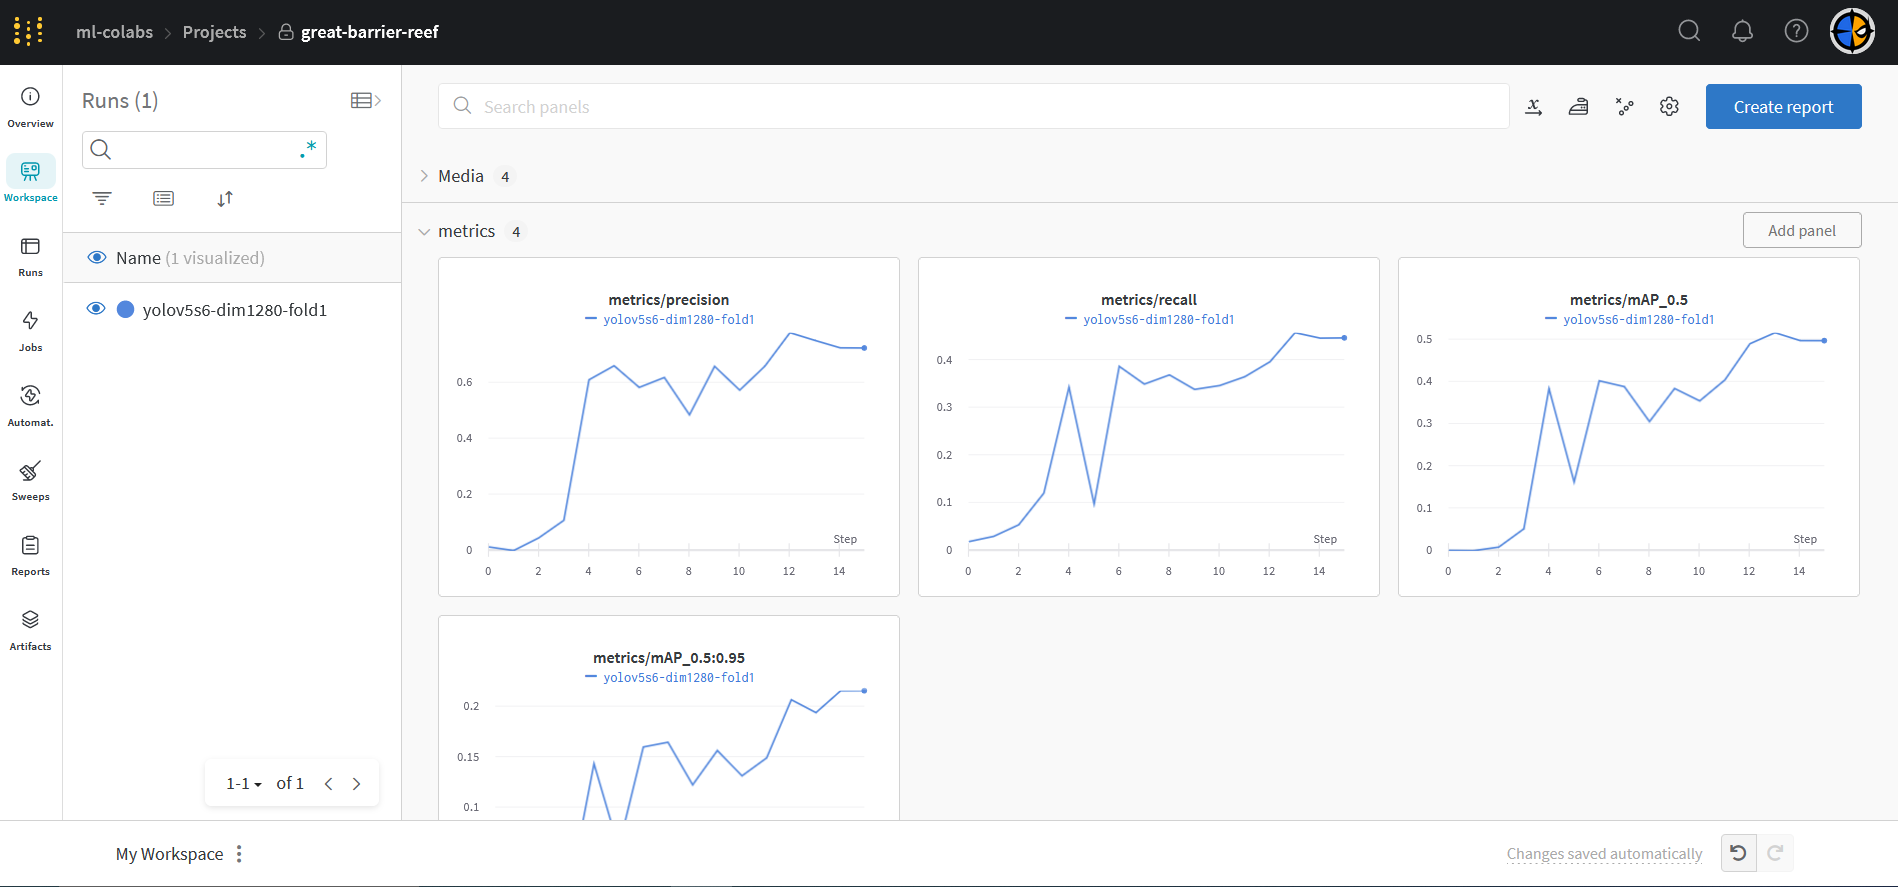

## Output Files

In [ ]:
OUTPUT_DIR = '{}/{}'.format(PROJECT, NAME)
!ls {OUTPUT_DIR}

# 📈 Class Distribution

In [ ]:
plt.figure(figsize = (10,10))
plt.axis('off')
plt.imshow(plt.imread(f'{OUTPUT_DIR}/labels_correlogram.jpg'));

In [ ]:
plt.figure(figsize = (10,10))
plt.axis('off')
plt.imshow(plt.imread(f'{OUTPUT_DIR}/labels.jpg'));

# 🔭 Batch Image

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 10))
plt.imshow(plt.imread(f'{OUTPUT_DIR}/train_batch0.jpg'))

plt.figure(figsize = (10, 10))
plt.imshow(plt.imread(f'{OUTPUT_DIR}/train_batch1.jpg'))

plt.figure(figsize = (10, 10))
plt.imshow(plt.imread(f'{OUTPUT_DIR}/train_batch2.jpg'))

## GT Vs Pred

In [ ]:
fig, ax = plt.subplots(3, 2, figsize = (2*9,3*5), constrained_layout = True)
for row in range(3):
    ax[row][0].imshow(plt.imread(f'{OUTPUT_DIR}/val_batch{row}_labels.jpg'))
    ax[row][0].set_xticks([])
    ax[row][0].set_yticks([])
    ax[row][0].set_title(f'{OUTPUT_DIR}/val_batch{row}_labels.jpg', fontsize = 12)
    
    ax[row][1].imshow(plt.imread(f'{OUTPUT_DIR}/val_batch{row}_pred.jpg'))
    ax[row][1].set_xticks([])
    ax[row][1].set_yticks([])
    ax[row][1].set_title(f'{OUTPUT_DIR}/val_batch{row}_pred.jpg', fontsize = 12)
plt.show()

# 🔍 Result

## Score Vs Epoch

In [ ]:
plt.figure(figsize=(30,15))
plt.axis('off')
plt.imshow(plt.imread(f'{OUTPUT_DIR}/results.png'));

## Confusion Matrix

In [ ]:
plt.figure(figsize=(12,10))
plt.axis('off')
plt.imshow(plt.imread(f'{OUTPUT_DIR}/confusion_matrix.png'));

## Metrics

In [ ]:
for metric in ['F1', 'PR', 'P', 'R']:
    print(f'Metric: {metric}')
    plt.figure(figsize=(12,10))
    plt.axis('off')
    plt.imshow(plt.imread(f'{OUTPUT_DIR}/{metric}_curve.png'));
    plt.show()

## Please Upvote if you find this Helpful

# ✂️ Remove Files

In [ ]:
!rm -r {IMAGE_DIR}
!rm -r {LABEL_DIR}

<div align="center"><img src="https://www.pngall.com/wp-content/uploads/2018/04/Under-Construction-PNG-File.png" width=600>